# Lab 3: Building Agentic Document Understanding

In this lesson, you will build an agent that combines tools for OCR, layout detection, reading order and Vision-Language Model (VLM).

**Learning Objectives:**
- Use PaddleOCR for text parsing and layout detection
- Use LayoutReader for sorting parsed text into reading order 
- Build VLM tools for chart and table analysis

## Background

LayoutReader is a model for determining reading order. By sorting information on each page, the model captures the logical sequence of text parsed from the document. For documents with multiple columns, floating captions, margin annotations, etc the reading order can be complex. 

- Input: Bounding boxes normalized to 0-1000 range
- Output: Reading order position for each box

LayoutReader uses LayoutLMv3 which was developed by Microsoft on the ReadingBank dataset (500,000+ annotated pages).

## Outline

- [1. Text Extraction with PaddleOCR + LayoutLM Ordering](#1)
  - [1.1. Running OCR on the Document](#1-1)
  - [1.2. Visualizing OCR Bounding Boxes](#1-2)
  - [1.3. Structuring OCR Results with a Dataclass](#1-3)
  - [1.4. LayoutLM Reading Order](#1-4)
  - [1.5. Visualizing the Reading Order](#1-5)
  - [1.6. Creating the Ordered Text Output](#1-6)
- [2. Layout Detection with PaddleOCR](#2)
  - [2.1. Processing Document Layout](#2-1)
  - [2.2. Structuring Layout Results](#2-2)
  - [2.3. Visualizing Layout Detection](#2-3)
  - [2.4. Cropping Regions for Agent Tools](#2-4)
- [3. Agent Tools](#3)
  - [3.1. VLM Helper and Prompts](#3-1)
  - [3.2. Creating the AnalyzeChart Tool](#3-2)
  - [3.3. Creating the AnalyzeTable Tool](#3-3)
  - [3.4. Testing the Tools](#3-4)
- [4. LangChain Agent](#4)
  - [4.1. Formatting Context for the Agent](#4-1)
  - [4.2. Creating the System Prompt](#4-2)
  - [4.3. Assembling the Agent](#4-3)
  - [4.4. Testing the Agent](#4-4)

## Architecture Overview 

<div align="center">
    <img src="architecture.png" width="700">
</div>

## Setup

Load environment variables including the OpenAI API key for VLM tools and agent.

In [1]:
import os
from dotenv import load_dotenv

_ = load_dotenv(override=True)

Import libraries:
- **Pillow** for image loading and manipulation
- **cv2 (OpenCV)** for image processing and bounding box visualization
- **matplotlib** for result visualization
- **numpy** for numerical operations on arrays
- **dataclass** for structured data storage
- **typing** for type hints

In [2]:
from PIL import Image
from pathlib import Path
import cv2
import matplotlib.pyplot as plt
import numpy as np
from dataclasses import dataclass
from typing import List, Dict, Any

<a id="1"></a>

## 1. Text Extraction with PaddleOCR + LayoutLM Ordering

Extract text and determine reading order using PaddleOCR and LayoutLM.

PaddleOCR returns three components for each detected text region:
- **Recognized text** strings
- **Confidence scores**
- **Bounding box coordinates** (4-point polygons)

Checking connectivity to the model hosters, this may take a while. To bypass this check, set `DISABLE_MODEL_SOURCE_CHECK` to `True`.
/usr/local/lib/python3.11/site-packages/paddle/utils/cpp_extension/extension_utils.py:711: UserWarning: No ccache found. Please be aware that recompiling all source files may be required. You can download and install ccache from: https://github.com/ccache/ccache/blob/master/doc/INSTALL.md
  warnings.warn(warning_message)
Creating model: ('PP-LCNet_x1_0_doc_ori', None)
Using official model (PP-LCNet_x1_0_doc_ori), the model files will be automatically downloaded and saved in `/home/jovyan/.paddlex/official_models/PP-LCNet_x1_0_doc_ori`.


Fetching 6 files:   0%|          | 0/6 [00:00<?, ?it/s]

.gitattributes: 0.00B [00:00, ?B/s]

config.json: 0.00B [00:00, ?B/s]

README.md: 0.00B [00:00, ?B/s]

inference.yml:   0%|          | 0.00/766 [00:00<?, ?B/s]

inference.json: 0.00B [00:00, ?B/s]

inference.pdiparams:   0%|          | 0.00/6.75M [00:00<?, ?B/s]

Creating model: ('UVDoc', None)
Using official model (UVDoc), the model files will be automatically downloaded and saved in `/home/jovyan/.paddlex/official_models/UVDoc`.


Fetching 6 files:   0%|          | 0/6 [00:00<?, ?it/s]

config.json: 0.00B [00:00, ?B/s]

inference.yml:   0%|          | 0.00/330 [00:00<?, ?B/s]

.gitattributes: 0.00B [00:00, ?B/s]

README.md: 0.00B [00:00, ?B/s]

inference.json: 0.00B [00:00, ?B/s]

inference.pdiparams:   0%|          | 0.00/32.1M [00:00<?, ?B/s]

Creating model: ('PP-LCNet_x1_0_textline_ori', None)
Using official model (PP-LCNet_x1_0_textline_ori), the model files will be automatically downloaded and saved in `/home/jovyan/.paddlex/official_models/PP-LCNet_x1_0_textline_ori`.


Fetching 6 files:   0%|          | 0/6 [00:00<?, ?it/s]

inference.yml:   0%|          | 0.00/735 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

config.json: 0.00B [00:00, ?B/s]

inference.json: 0.00B [00:00, ?B/s]

inference.pdiparams:   0%|          | 0.00/6.74M [00:00<?, ?B/s]

.gitattributes: 0.00B [00:00, ?B/s]

Creating model: ('PP-OCRv5_server_det', None)
Using official model (PP-OCRv5_server_det), the model files will be automatically downloaded and saved in `/home/jovyan/.paddlex/official_models/PP-OCRv5_server_det`.


Fetching 6 files:   0%|          | 0/6 [00:00<?, ?it/s]

.gitattributes: 0.00B [00:00, ?B/s]

README.md: 0.00B [00:00, ?B/s]

inference.pdiparams:   0%|          | 0.00/87.9M [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

inference.yml:   0%|          | 0.00/903 [00:00<?, ?B/s]

inference.json: 0.00B [00:00, ?B/s]

Creating model: ('en_PP-OCRv5_mobile_rec', None)
Using official model (en_PP-OCRv5_mobile_rec), the model files will be automatically downloaded and saved in `/home/jovyan/.paddlex/official_models/en_PP-OCRv5_mobile_rec`.


Fetching 6 files:   0%|          | 0/6 [00:00<?, ?it/s]

.gitattributes: 0.00B [00:00, ?B/s]

inference.yml: 0.00B [00:00, ?B/s]

README.md: 0.00B [00:00, ?B/s]

inference.json: 0.00B [00:00, ?B/s]

inference.pdiparams:   0%|          | 0.00/7.77M [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

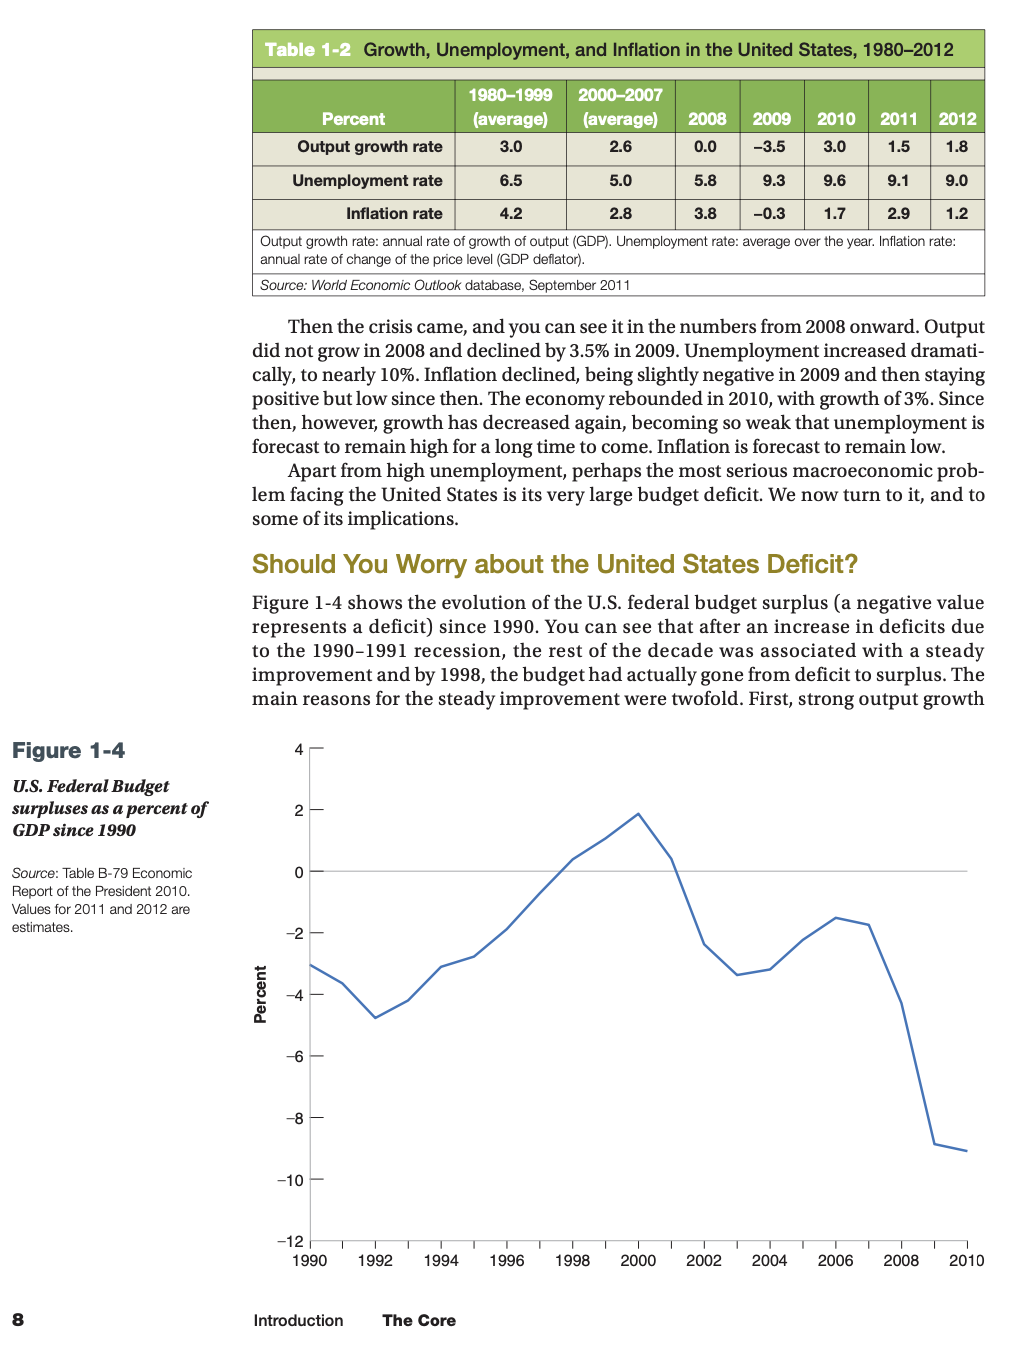

In [3]:
from paddleocr import PaddleOCR

# Initialize PaddleOCR 
ocr = PaddleOCR(lang='en')

# Load image
image_path = "report_original.png"
display(Image.open(image_path))

<a id="1-1"></a>

### 1.1. Running OCR on the Document

Run OCR on the document (the same economics report from previous lessons).

In [4]:
# Run OCR 
result = ocr.predict(image_path)
page = result[0]

texts = page['rec_texts']      # recognized text strings
scores = page['rec_scores']    # confidence scores
boxes = page['rec_polys']      # bounding box coordinates

print(f"Extracted {len(texts)} text regions")
print("\nFirst 10 regions:")
for text, score, box in list(zip(texts, scores, boxes))[:10]:
    coords = box.astype(int).tolist()
    print(f"{text:40} | {score:.3f} | {coords}")

Extracted 82 text regions

First 10 regions:
Table 1-2 Growth, Unemployment, and Inflation in the United States, 19802012 | 0.978 | [[221, 13], [986, 7], [986, 38], [222, 44]]
19801999                                 | 1.000 | [[443, 66], [541, 66], [541, 87], [443, 87]]
20002007                                 | 1.000 | [[561, 65], [661, 62], [662, 87], [561, 89]]
Percent                                  | 1.000 | [[287, 91], [362, 91], [362, 116], [287, 116]]
(average)                                | 1.000 | [[446, 89], [537, 91], [536, 120], [445, 118]]
(average)                                | 1.000 | [[565, 90], [655, 88], [656, 116], [565, 118]]
2008                                     | 1.000 | [[679, 87], [731, 87], [731, 113], [679, 113]]
2009                                     | 1.000 | [[750, 86], [800, 86], [800, 112], [750, 112]]
2010                                     | 1.000 | [[822, 88], [873, 88], [873, 111], [822, 111]]
2011                                     | 1

<a id="1-2"></a>

### 1.2. Visualizing OCR Bounding Boxes

Draw bounding boxes to verify OCR detection. Each text line, table cell, and label gets its own box.

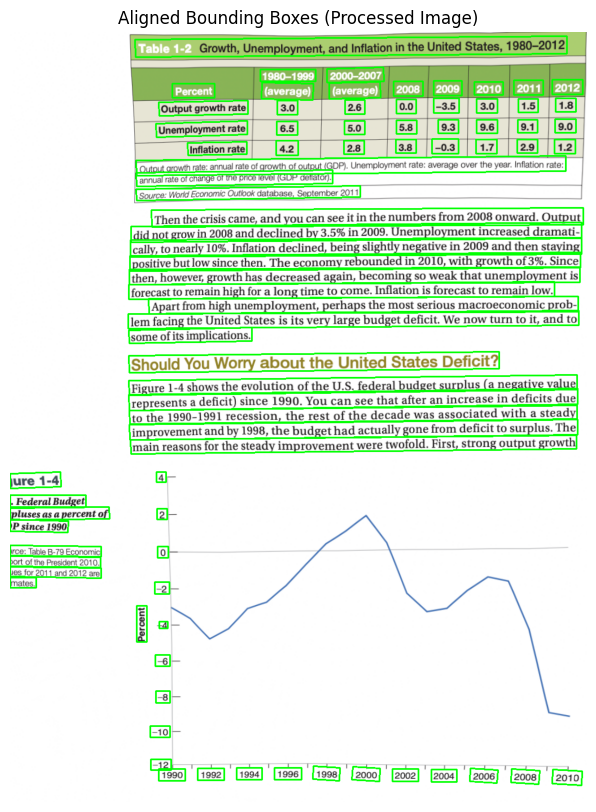

In [5]:
processed_img = page['doc_preprocessor_res']['output_img']
img_plot = processed_img.copy()
show_text= False

for text, box in zip(texts, boxes):
    pts = np.array(box, dtype=int)
    cv2.polylines(img_plot, [pts], True, (0, 255, 0), 2)
    x, y = pts[0]
    if show_text:
        cv2.putText(img_plot, text, (x, y - 5), 
                    cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 0, 0), 2)

plt.figure(figsize=(8, 10))
plt.imshow(cv2.cvtColor(img_plot, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.title("Aligned Bounding Boxes (Processed Image)")
plt.show()

<a id="1-3"></a>

### 1.3. Structuring OCR Results with a Dataclass

Structure OCR output using an `OCRRegion` dataclass for cleaner code:
- Typed structure for each text region
- `bbox_xyxy` property converts 4-point polygons to `[x1, y1, x2, y2]` format

In [6]:
# Store OCR results in a structured format
@dataclass
class OCRRegion:
    text: str
    bbox: list  # [[x1,y1], [x2,y2], [x3,y3], [x4,y4]]
    confidence: float
    
    @property
    def bbox_xyxy(self):
        """Return bbox as [x1, y1, x2, y2] format."""
        x_coords = [p[0] for p in self.bbox]
        y_coords = [p[1] for p in self.bbox]
        return [min(x_coords), min(y_coords), max(x_coords), max(y_coords)]

ocr_regions: List[OCRRegion] = []
for text, score, box in zip(texts, scores, boxes):
    ocr_regions.append(OCRRegion(
        text=text, 
        bbox=box.astype(int).tolist(), 
        confidence=score
    ))

print(f"Stored {len(ocr_regions)} OCR regions")

Stored 82 OCR regions


<a id="1-4"></a>

### 1.4. LayoutLM Reading Order

Simple ordering (eg top-to-bottom, left-to-right) does not apply to our complex document. We will use LayoutReader which itself uses LayoutLMv3 model. Hugging Face contains the LayoutLMv3 model. Additionally we use helper functions for LayoutReader available at this [repository](https://github.com/ppaanngggg/layoutreader.git). 

In [7]:
from transformers import LayoutLMv3ForTokenClassification
from layoutreader.v3.helpers import prepare_inputs, boxes2inputs, parse_logits

# Load LayoutReader model
print("Loading LayoutReader model...")
model_slug = "hantian/layoutreader"
layout_model = LayoutLMv3ForTokenClassification.from_pretrained(model_slug)
print("Model loaded successfully!")

Loading LayoutReader model...


config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/713M [00:00<?, ?B/s]

Model loaded successfully!


Now implement a reading order function called `get_reading_order`: 

1. **Calculate image dimensions** - Estimate size from bounding boxes with 10% padding
2. **Normalize coordinates** - Scale boxes to 0-1000 range for LayoutLM
3. **Prepare inputs** - Convert to transformer format
4. **Run inference** - Get model predictions
5. **Parse results** - Extract reading order from output logits

In [8]:
def get_reading_order(ocr_regions):
    """
    Use LayoutReader to determine reading order of OCR regions.
    Returns list of reading order positions for each region index.
    """
    # 1. Calculate image dimensions from bounding boxes (with padding)
    max_x = max_y = 0
    for region in ocr_regions:
        x1, y1, x2, y2 = region.bbox_xyxy
        max_x = max(max_x, x2)
        max_y = max(max_y, y2)

    image_width = max_x * 1.1   # Add 10% padding
    image_height = max_y * 1.1

    # 2. Convert bboxes to LayoutReader format (normalized to 0-1000)
    boxes = []
    for region in ocr_regions:
        x1, y1, x2, y2 = region.bbox_xyxy
        # Normalize to 0-1000 range
        left = int((x1 / image_width) * 1000)
        top = int((y1 / image_height) * 1000)
        right = int((x2 / image_width) * 1000)
        bottom = int((y2 / image_height) * 1000)
        boxes.append([left, top, right, bottom])

    # 3. Prepare inputs
    inputs = boxes2inputs(boxes)
    inputs = prepare_inputs(inputs, layout_model)
    
    # 4. Run inference
    logits = layout_model(**inputs).logits.cpu().squeeze(0)
    
    # 5. Parse the model's outputs to get reading order
    reading_order = parse_logits(logits, len(boxes))

    return reading_order

# Get reading order
reading_order = get_reading_order(ocr_regions)

print(f"Reading order determined for {len(reading_order)} regions")
print(f"First 20 positions: {reading_order[:20]}")

/usr/local/lib/python3.11/site-packages/transformers/modeling_utils.py:1621: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(


Reading order determined for 82 regions
First 20 positions: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]


<a id="1-5"></a>

### 1.5. Visualizing the Reading Order

Visualize reading order with numbered overlays on each region. Numbers follow the predicted reading sequence.

> **Note:** The model may produce some non-sequential jumps. For complex documents, you may need to fine-tune a custom layout model.

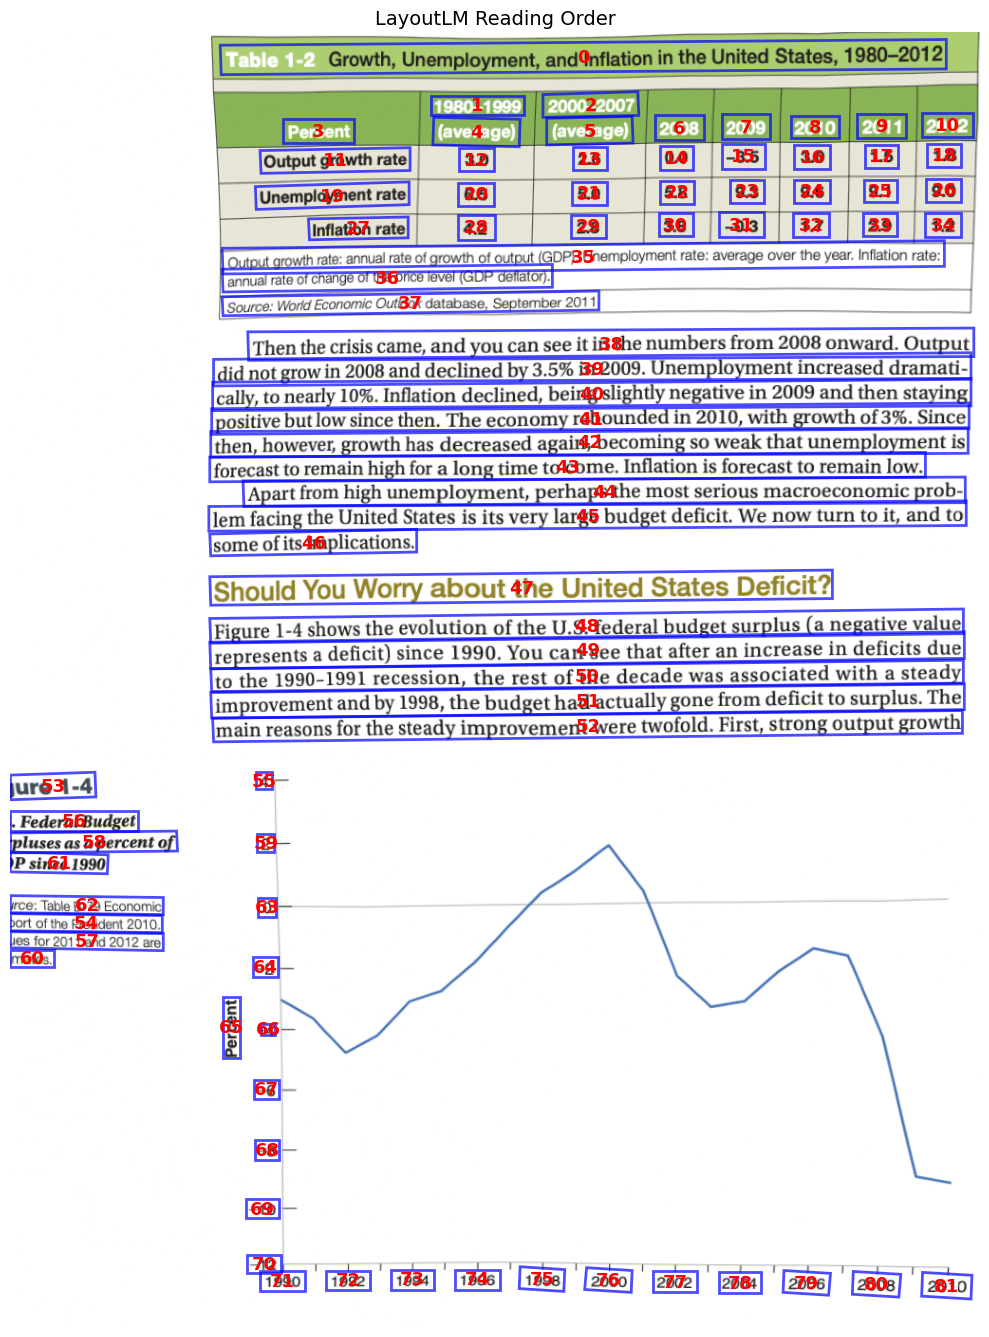

In [9]:
import matplotlib.patches as patches

def visualize_reading_order(ocr_regions, image_array, reading_order, title="Reading Order"):
    """
    Visualize OCR regions with their reading order numbers using matplotlib.
    """
    
    fig, ax = plt.subplots(1, figsize=(10, 14))
    ax.imshow(cv2.cvtColor(image_array, cv2.COLOR_BGR2RGB))
    
    # Create order mapping: index -> reading order position
    order_map = {i: order for i, order in enumerate(reading_order)}
    
    for i, region in enumerate(ocr_regions):
        bbox = region.bbox
        if bbox and len(bbox) >= 4:
            # Draw polygon
            ax.add_patch(patches.Polygon(bbox, linewidth=2, 
                                         edgecolor='blue',
                                         facecolor='none', alpha=0.7))
            # Add reading order number at center
            xs = [p[0] for p in bbox]
            ys = [p[1] for p in bbox]
            ax.text(sum(xs)/len(xs), sum(ys)/len(ys), 
                    str(order_map.get(i, i)),
                    fontsize=13, color='red', 
                    ha='center', va='center', fontweight='bold')
    
    ax.set_title(title, fontsize=14)
    ax.axis('off')
    plt.tight_layout()
    plt.show()

visualize_reading_order(ocr_regions, processed_img, 
                        reading_order, "LayoutLM Reading Order")

<a id="1-6"></a>

### 1.6. Creating the Ordered Text Output

Combine OCR text with reading order:
1. Pair each region with its reading position
2. Sort by position
3. Return structured list with position, text, confidence, and bbox

This ordered text provides agent context for answering text-based questions without VLM calls.

In [10]:
# Create ordered text content
def get_ordered_text(ocr_regions, reading_order):
    """
    Return OCR regions sorted by reading order
    with their text and confidence.
    """
    # 1. Create (reading_position, index, region) tuples and sort
    indexed_regions = [(reading_order[i], 
                        i, 
                        ocr_regions[i]) for i in range(len(ocr_regions))]
    
    # 2. Sort by reading position
    indexed_regions.sort(key=lambda x: x[0])  
    
    # 3. Extract ordered text info
    ordered_text = []
    for position, original_idx, region in indexed_regions:
        ordered_text.append({
            "position": position,
            "text": region.text,
            "confidence": region.confidence,
            "bbox": region.bbox_xyxy
        })
    
    return ordered_text

ordered_text = get_ordered_text(ocr_regions, reading_order)

print("Text in reading order:")
print("=" * 70)
ordered_text[:5]

Text in reading order:


[{'position': 0,
  'text': 'Table 1-2 Growth, Unemployment, and Inflation in the United States, 19802012',
  'confidence': 0.9775537252426147,
  'bbox': [221, 7, 986, 44]},
 {'position': 1,
  'text': '19801999',
  'confidence': 0.999964714050293,
  'bbox': [443, 66, 541, 87]},
 {'position': 2,
  'text': '20002007',
  'confidence': 0.9999071359634399,
  'bbox': [561, 62, 662, 89]},
 {'position': 3,
  'text': 'Percent',
  'confidence': 0.999927818775177,
  'bbox': [287, 91, 362, 116]},
 {'position': 4,
  'text': '(average)',
  'confidence': 0.9999554753303528,
  'bbox': [445, 89, 537, 120]}]

<a id="2"></a>

## 2. Layout Detection with PaddleOCR

Beyond text extraction, identify **content types** using layout detection.

PaddleOCR's `LayoutDetection` identifies document structure. Each region includes:
- **label**: Content type (text, table, chart, figure, etc.)
- **score**: Confidence score
- **bbox**: Bounding box in XYXY format

In [11]:
from paddleocr import LayoutDetection

# Initialize layout detection 
layout_engine = LayoutDetection()

Using official model (PP-DocLayout_plus-L), the model files will be automatically downloaded and saved in `/home/jovyan/.paddlex/official_models/PP-DocLayout_plus-L`.


Fetching 6 files:   0%|          | 0/6 [00:00<?, ?it/s]

config.json: 0.00B [00:00, ?B/s]

inference.json: 0.00B [00:00, ?B/s]

README.md: 0.00B [00:00, ?B/s]

inference.yml: 0.00B [00:00, ?B/s]

.gitattributes: 0.00B [00:00, ?B/s]

inference.pdiparams:   0%|          | 0.00/129M [00:00<?, ?B/s]

<a id="2-1"></a>

### 2.1. Processing Document Layout

Run layout detection to identify content types (text blocks, charts, titles, tables, etc.).

In [12]:
# Process document layout 
def process_document(image_path):
    """Get layout regions from document."""
    layout_result = layout_engine.predict(image_path)
    
    regions = []
    for box in layout_result[0]['boxes']:
        regions.append({
            'label': box['label'],
            'score': box['score'],
            'bbox': box['coordinate'],  # [x1, y1, x2, y2]
        })
    
    # Sort by confidence
    regions = sorted(regions, key=lambda x: x['score'], reverse=True)
    return regions

layout_results = process_document(image_path)

print(f"Detected {len(layout_results)} layout regions:")
for r in layout_results:
    print(f"  {r['label']:20} score: {r['score']:.3f}  bbox: {[int(x) for x in r['bbox']]}")

Detected 15 layout regions:
  text                 score: 0.983  bbox: [245, 315, 983, 454]
  text                 score: 0.976  bbox: [245, 590, 982, 707]
  text                 score: 0.973  bbox: [246, 460, 983, 526]
  chart                score: 0.973  bbox: [249, 737, 982, 1271]
  paragraph_title      score: 0.926  bbox: [247, 550, 857, 573]
  text                 score: 0.847  bbox: [7, 863, 191, 932]
  number               score: 0.823  bbox: [12, 1311, 24, 1324]
  table                score: 0.751  bbox: [251, 69, 983, 293]
  footer               score: 0.735  bbox: [250, 1310, 455, 1326]
  table                score: 0.713  bbox: [251, 74, 982, 227]
  figure_title         score: 0.707  bbox: [261, 37, 953, 58]
  text                 score: 0.661  bbox: [256, 275, 629, 291]
  text                 score: 0.594  bbox: [8, 775, 207, 836]
  paragraph_title      score: 0.582  bbox: [8, 738, 125, 759]
  text                 score: 0.531  bbox: [255, 232, 958, 267]


Top five detected regions:

In [13]:
layout_results[0:5]

[{'label': 'text',
  'score': 0.9832394123077393,
  'bbox': [np.float32(245.83952),
   np.float32(315.08896),
   np.float32(983.7128),
   np.float32(454.9894)]},
 {'label': 'text',
  'score': 0.9764299988746643,
  'bbox': [np.float32(245.7429),
   np.float32(590.87714),
   np.float32(982.7049),
   np.float32(707.9059)]},
 {'label': 'text',
  'score': 0.9731149077415466,
  'bbox': [np.float32(246.2163),
   np.float32(460.42484),
   np.float32(983.4213),
   np.float32(526.6737)]},
 {'label': 'chart',
  'score': 0.9727388024330139,
  'bbox': [np.float32(249.72392),
   np.float32(737.71814),
   np.float32(982.07153),
   np.float32(1271.0194)]},
 {'label': 'paragraph_title',
  'score': 0.9260663986206055,
  'bbox': [np.float32(247.40016),
   np.float32(550.6846),
   np.float32(857.22504),
   np.float32(573.2925)]}]

<a id="2-2"></a>

### 2.2. Structuring Layout Results

Create a `LayoutRegion` dataclass with unique IDs for tool references.

In [14]:
@dataclass
class LayoutRegion:
    region_id: int
    region_type: str
    bbox: list  # [x1, y1, x2, y2]
    confidence: float
    
# Store layout regions in structured format
layout_regions: List[LayoutRegion] = []
for i, r in enumerate(layout_results):
    layout_regions.append(LayoutRegion(
        region_id=i,
        region_type=r['label'],
        bbox=[int(x) for x in r['bbox']],
        confidence=r['score']
    ))

print(f"Stored {len(layout_regions)} layout regions")

Stored 15 layout regions


<a id="2-3"></a>

### 2.3. Visualizing Layout Detection

Visualize layout regions with color-coded boxes showing region ID, type, and confidence.

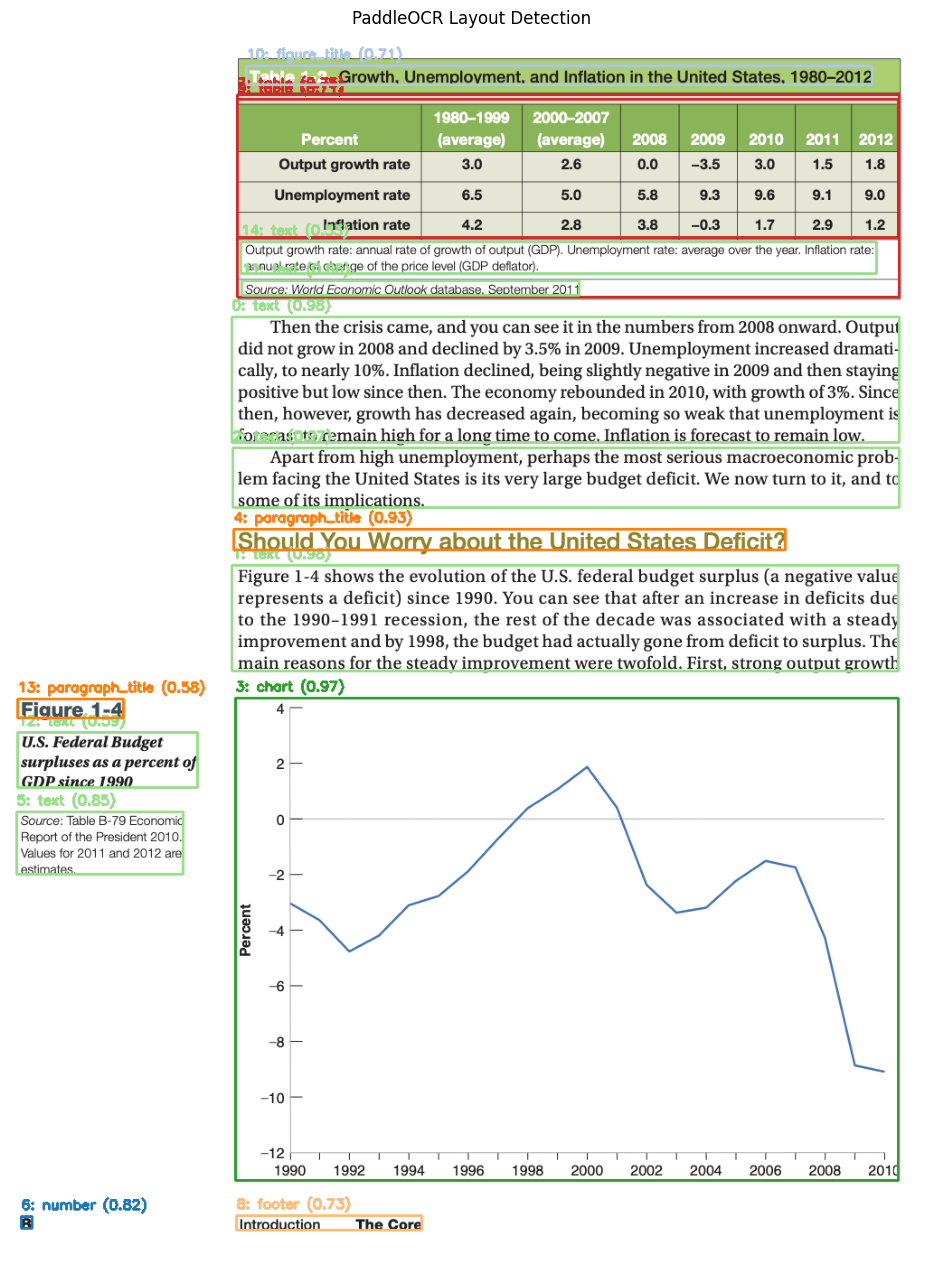

In [15]:
# Visualize layout detection 
from matplotlib import colormaps

def visualize_layout(image_path, layout_regions, min_confidence=0.5, 
                     title="Layout Detection"):
    """
    Visualize layout detection results using cv2 (same pattern as L2).
    """
    img = cv2.imread(image_path)
    img_plot = img.copy()
    
    # Get unique labels and generate colors
    labels = list(set(r.region_type for r in layout_regions))
    cmap = colormaps.get_cmap('tab20')
    color_map = {}
    for i, label in enumerate(labels):
        rgba = cmap(i % 20)
        color_map[label] = (int(rgba[2]*255), int(rgba[1]*255), int(rgba[0]*255))
    
    for region in layout_regions:
        if region.confidence < min_confidence:
            continue
            
        color = color_map[region.region_type]
        x1, y1, x2, y2 = region.bbox
        
        # Draw rectangle
        pts = np.array([[x1, y1], [x2, y1], [x2, y2], [x1, y2]], dtype=int)
        cv2.polylines(img_plot, [pts], True, color, 2)
        
        # Add label
        text = f"{region.region_id}: {region.region_type} ({region.confidence:.2f})"
        cv2.putText(img_plot, text, (x1, y1-8), 
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)
    
    plt.figure(figsize=(12, 16))
    plt.imshow(cv2.cvtColor(img_plot, cv2.COLOR_BGR2RGB))
    plt.axis("off")
    plt.title(title)
    plt.show()
    
    return img_plot

visualize_layout(image_path, layout_regions, 
                 min_confidence=0.5, title="PaddleOCR Layout Detection");

<a id="2-4"></a>

### 2.4. Cropping Regions for Agent Tools

Prepare cropped regions for VLM analysis:
- **Focused analysis** - VLM sees only relevant content
- **Reduced noise** - No surrounding text interference
- **Lower costs** - Smaller images reduce API costs

Images are base64-encoded for vision API compatibility.

In [16]:
import base64
from io import BytesIO

# Crop and save layout regions for agent tools
def crop_region(image, bbox, padding=10):
    """Crop a region from image with optional padding."""
    x1, y1, x2, y2 = bbox
    x1 = max(0, x1 - padding)
    y1 = max(0, y1 - padding)
    x2 = min(image.width, x2 + padding)
    y2 = min(image.height, y2 + padding)
    return image.crop((x1, y1, x2, y2))

def image_to_base64(img):
    """Convert PIL Image to base64 string."""
    buffer = BytesIO()
    img.save(buffer, format='PNG')
    return base64.b64encode(buffer.getvalue()).decode('utf-8')

# Load image for cropping
pil_image = Image.open(image_path)

# Store cropped regions in dictionary
region_images = {}
for region in layout_regions:
    cropped = crop_region(pil_image, region.bbox)
    region_images[region.region_id] = {
        'image': cropped,
        'base64': image_to_base64(cropped),
        'type': region.region_type,
        'bbox': region.bbox
    }

print(f"Cropped {len(region_images)} regions")

# Also store full image
full_image_base64 = image_to_base64(pil_image)

Cropped 15 regions


Display all cropped regions available to the agent:

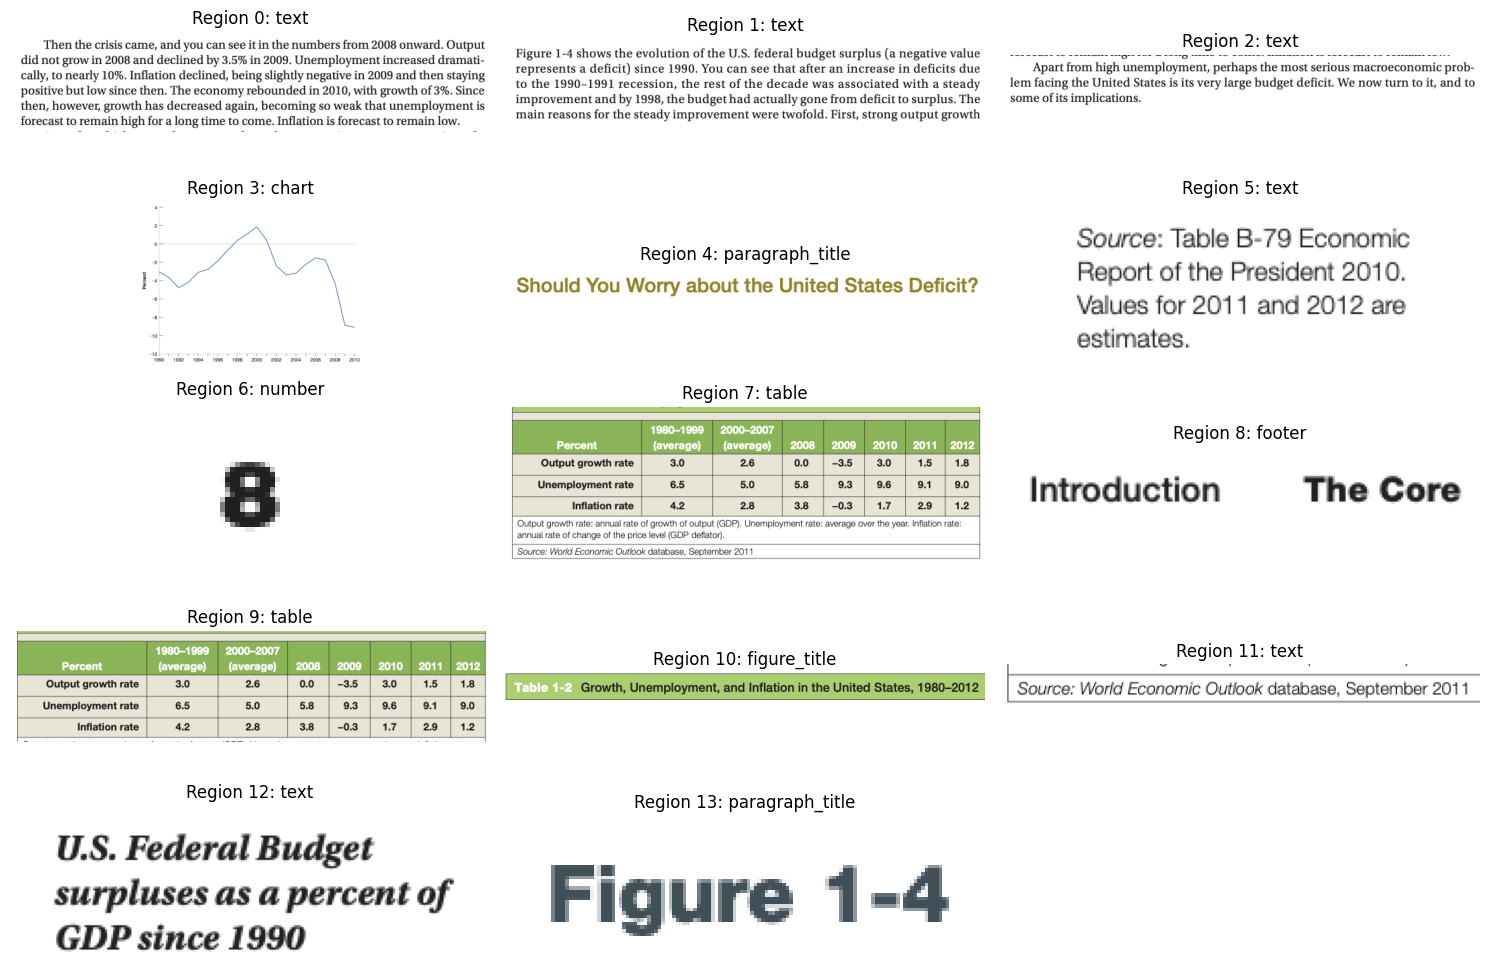

In [17]:
# Show cropped regions
fig, axes = plt.subplots(5, 3, figsize=(15, 10))
axes = axes.flatten()

for i, (region_id, data) in enumerate(list(region_images.items())[:14]):
    axes[i].imshow(data['image'])
    axes[i].set_title(f"Region {region_id}: {data['type']}")
    axes[i].axis('off')

# Hide unused subplots
for j in range(i+1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

<a id="3"></a>

## 3. Agent Tools

Create two specialized VLM tools with optimized prompts:
- **AnalyzeChart**: Interpret charts and figures
- **AnalyzeTable**: Extract structured table data

Specialized tools enable content-specific prompts and structured JSON outputs.

In [18]:
from langchain.tools import tool
from langchain_openai import ChatOpenAI
from langchain.schema import HumanMessage

# Initialize VLM for tools
vlm = ChatOpenAI(model="gpt-4o-mini", temperature=0)

<a id="3-1"></a>

### 3.1. VLM Helper and Prompts

Prompts define structured VLM output with three components:
1. **Role definition** (e.g., "Chart Analysis specialist")
2. **Extraction fields** (chart type, axes, data points)
3. **JSON template** for consistent formatting

In [19]:
# Tool prompts
CHART_ANALYSIS_PROMPT = """You are a Chart Analysis specialist. 
Analyze this chart/figure image and extract:

1. **Chart Type**: (line, bar, scatter, pie, etc.)
2. **Title**: (if visible)
3. **Axes**: X-axis label, Y-axis label, and tick values
4. **Data Points**: Key values (peaks, troughs, endpoints)
5. **Trends**: Overall pattern description
6. **Legend**: (if present)

Return a JSON object with this structure:
```json
{{
  "chart_type": "...",
  "title": "...",
  "x_axis": {{"label": "...", "ticks": [...]}},
  "y_axis": {{"label": "...", "ticks": [...]}},
  "key_data_points": [...],
  "trends": "...",
  "legend": [...]
}}
```
"""

In [20]:
TABLE_ANALYSIS_PROMPT = """You are a Table Extraction specialist. 
Extract structured data from this table image.

1. **Identify Structure**: 
    - Column headers, row labels, data cells
2. **Extract All Data**: 
    - Preserve exact values and alignment
3. **Handle Special Cases**: 
    - Merged cells, empty cells (mark as null), multi-line headers

Return a JSON object with this structure:
```json
{{
  "table_title": "...",
  "column_headers": ["header1", "header2", ...],
  "rows": [
    {{"row_label": "...", "values": [val1, val2, ...]}},
    ...
  ],
  "notes": "any footnotes or source info"
}}
```
"""

**VLM Helper Function** 

Call VLM with multimodal messages containing prompt and base64-encoded image.

In [21]:
def call_vlm_with_image(image_base64: str, prompt: str) -> str:
    """Call VLM with an image and prompt."""
    message = HumanMessage(
        content=[
            {"type": "text", "text": prompt},
            {
                "type": "image_url",
                "image_url": {"url": f"data:image/png;base64,{image_base64}"}
            }
        ]
    )
    response = vlm.invoke([message])
    return response.content

<a id="3-2"></a>

### 3.2. Creating the AnalyzeChart Tool

The `@tool` decorator converts functions to agent-usable tools. This tool validates region existence, retrieves cropped images, and calls the VLM with the chart analysis prompt.

In [22]:
@tool
def AnalyzeChart(region_id: int) -> str:
    """Analyze a chart or figure region using VLM. 
    Use this tool when you need to extract data from charts, graphs, or figures.
    
    Args:
        region_id: The ID of the layout region to analyze (must be a chart/figure type)
    
    Returns:
        JSON string with chart type, axes, data points, and trends
    """
    if region_id not in region_images:
        return f"Error: Region {region_id} not found. Available regions: {list(region_images.keys())}"
    
    region_data = region_images[region_id]
    
    if region_data['type'] not in ['chart', 'figure']:
        return f"Warning: Region {region_id} is type '{region_data['type']}', not a chart/figure. Proceeding anyway."
    
    result = call_vlm_with_image(region_data['base64'], CHART_ANALYSIS_PROMPT)
    
    return result

print("AnalyzeChart tool defined")

AnalyzeChart tool defined


<a id="3-3"></a>

### 3.3. Creating the AnalyzeTable Tool

Create the table extraction tool using the table-specific prompt for structured data with headers and rows.

In [23]:
@tool
def AnalyzeTable(region_id: int) -> str:
    """
    Extract structured data from a table region using VLM.
    Use this tool when you need to extract tabular data 
    with headers and rows.
    
    Args:
        region_id: The ID of the layout region to analyze (must be a table type)
    
    Returns:
        JSON string with table headers, rows, and any notes
    """
    if region_id not in region_images:
        return f"Error: Region {region_id} not found. Available regions: {list(region_images.keys())}"
    
    region_data = region_images[region_id]
    
    if region_data['type'] != 'table':
        return f"Warning: Region {region_id} is type '{region_data['type']}', not a table. Proceeding anyway."
    
    result = call_vlm_with_image(region_data['base64'], TABLE_ANALYSIS_PROMPT)
    return result

print("AnalyzeTable tool defined")

AnalyzeTable tool defined


<a id="3-4"></a>

### 3.4. Testing the Tools

Test tools individually to verify VLM connection and prompt effectiveness.

Analyze the first chart region. Data points are approximate—VLMs have limitations in precise visual localization.

In [24]:
# Test the tools
print("Testing AnalyzeChart...")
chart_regions = [r for r in layout_regions if r.region_type in ['chart', 'figure']]
if chart_regions:
    test_result = AnalyzeChart.invoke({"region_id": chart_regions[0].region_id})
    print(f"Chart analysis result:\n{test_result[:500]}...")
else:
    print("No chart regions found")

Testing AnalyzeChart...
Chart analysis result:
```json
{
  "chart_type": "line",
  "title": "",
  "x_axis": {
    "label": "Year",
    "ticks": [1990, 1992, 1994, 1996, 1998, 2000, 2002, 2004, 2006, 2008, 2010]
  },
  "y_axis": {
    "label": "Percent",
    "ticks": [-12, -10, -8, -6, -4, -2, 0, 2, 4]
  },
  "key_data_points": [
    {"year": 1990, "value": -4},
    {"year": 2000, "value": 2},
    {"year": 2008, "value": -10}
  ],
  "trends": "The chart shows a fluctuating trend with a peak around 2000, followed by a decline towards 2008.",
 ...


Test the table tool. Works well for simple tables but struggles with complex layouts and may hallucinate.

In [25]:
# Test table tool
print("Testing AnalyzeTable...")
table_regions = [r for r in layout_regions if r.region_type == 'table']
if table_regions:
    test_result = AnalyzeTable.invoke({"region_id": table_regions[0].region_id})
    print(f"Table analysis result:\n{test_result[:500]}...")
else:
    print("No table regions found")

Testing AnalyzeTable...
Table analysis result:
```json
{
  "table_title": "Economic Indicators",
  "column_headers": ["Percent", "1980–1999 (average)", "2000–2007 (average)", "2008", "2009", "2010", "2011", "2012"],
  "rows": [
    {"row_label": "Output growth rate", "values": [3.0, 2.6, 0.0, -3.5, 3.0, 1.5, 1.8]},
    {"row_label": "Unemployment rate", "values": [6.5, 5.0, 5.8, 9.3, 9.6, 9.1, 9.0]},
    {"row_label": "Inflation rate", "values": [4.2, 2.8, 3.8, -0.3, 1.7, 2.9, 1.2]}
  ],
  "notes": "Output growth rate: annual rate of growth ...


<a id="4"></a>

## 4. LangChain Agent

Build the agent to orchestrate all components:
1. Receive question about document
2. Read system prompt with OCR text and layout info
3. Decide whether to answer from text or use tools
4. Call appropriate tools for visual content
5. Combine information into coherent response

Verify data structures: ordered text (OCR + LayoutLM) and layout regions (layout detection).

In [26]:
ordered_text[0]

{'position': 0,
 'text': 'Table 1-2 Growth, Unemployment, and Inflation in the United States, 19802012',
 'confidence': 0.9775537252426147,
 'bbox': [221, 7, 986, 44]}

In [27]:
layout_regions[0]

LayoutRegion(region_id=0, region_type='text', bbox=[245, 315, 983, 454], confidence=0.9832394123077393)

<a id="4-1"></a>

### 4.1. Formatting Context for the Agent

Convert data structures to readable text for the system prompt—the agent's "memory" of the document.

In [28]:
#Prepare context for the agent
def format_ordered_text(ordered_text, max_items=50):
    """Format ordered text for the system prompt."""
    lines = []
    for item in ordered_text[:max_items]:
        lines.append(f"[{item['position']}] {item['text']}")
    
    if len(ordered_text) > max_items:
        lines.append(f"... and {len(ordered_text) - max_items} more text regions")
    
    return "\n".join(lines)

def format_layout_regions(layout_regions):
    """Format layout regions for the system prompt."""
    lines = []
    for region in layout_regions:
        lines.append(f"  - Region {region.region_id}: {region.region_type} (confidence: {region.confidence:.3f})")
    return "\n".join(lines)

# Create the formatted strings
ordered_text_str = format_ordered_text(ordered_text)
layout_regions_str = format_layout_regions(layout_regions)

print("Formatted context for agent:")
print(f"- Ordered text: {len(ordered_text_str)} chars")
print(f"- Layout regions: {len(layout_regions_str)} chars")

Formatted context for agent:
- Ordered text: 1585 chars
- Layout regions: 626 chars


<a id="4-2"></a>

### 4.2. Creating the System Prompt

Construct the system prompt with:
- **Role definition**: Document Intelligence Agent
- **Document context**: OCR text in reading order
- **Layout information**: Region types and IDs
- **Tool descriptions**: When to use each tool
- **Instructions**: How to handle different content types

In [29]:
# System prompt for the agent
SYSTEM_PROMPT = f"""You are a Document Intelligence Agent. 
You analyze documents by combining OCR text with visual analysis tools.

## Document Text (in reading order)
The following text was extracted using OCR and ordered using LayoutLM.

{ordered_text_str}

## Document Layout Regions
The following regions were detected in the document:

{layout_regions_str}

## Your Tools
- **AnalyzeChart(region_id)**: 
    - Use for chart/figure regions to extract data points, axes, and trends
- **AnalyzeTable(region_id)**: 
    - Use for table regions to extract structured tabular data

## Instructions
1. For TEXT regions: 
    - Use the OCR text provided above (it's already extracted)
2. For TABLE regions: 
    - Use the AnalyzeTable tool to get structured data
3. For CHART/FIGURE regions: 
    - Use the AnalyzeChart tool to extract visual data

When answering questions about the document, 
use the appropriate tools to get accurate information.
"""

print("System prompt created")
print(f"Total length: {len(SYSTEM_PROMPT)} characters")

System prompt created
Total length: 3101 characters


<a id="4-3"></a>

### 4.3. Assembling the Agent

Assemble the agent using `create_tool_calling_agent`:
- **Tools**: AnalyzeChart and AnalyzeTable
- **LLM**: GPT-4o-mini for cost efficiency
- **Prompt**: System context + user input + agent scratchpad
- **Verbose mode**: Shows agent reasoning process

In [30]:
# Initialize the agent (using LangChain 0.1.x API)
tools = [AnalyzeChart, AnalyzeTable]

# LLM for the agent 
agent_llm = ChatOpenAI(model="gpt-4o-mini", temperature=0)

from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain.agents import create_tool_calling_agent
from langchain.agents import AgentExecutor

prompt = ChatPromptTemplate.from_messages(
    [
        ("system",SYSTEM_PROMPT),
        ("user", "{input}"),
        MessagesPlaceholder(variable_name="agent_scratchpad"),
    ]
)


# 4. Create the tool-calling agent
agent = create_tool_calling_agent(agent_llm, tools, prompt)

# 5. Set up the AgentExecutor to run the tool-enabled loop
agent_executor = AgentExecutor(agent=agent, tools=tools, verbose=True)

<a id="4-4"></a>

### 4.4. Testing the Agent

Test the agent with three question types.

<p style="background-color:#f7fff8; padding:15px; border-width:3px; border-color:#e0f0e0; border-style:solid; border-radius:6px"> 🚨
&nbsp; <b>Different Run Results:</b> The output generated by AI chat models can vary with each execution due to their non-deterministic nature. Don't be surprised if your results differ from those shown in the video.</p>

**Test 1: Document Overview**

Ask a general question answerable from OCR text alone (no tool calls needed).

In [31]:
# Test the agent with a simple question
response = agent_executor.invoke({
    "input": "What types of content are in this document?"
              "List the main sections.",
})
print("\n" + "="*60)
print("Agent Response:")
print("="*60)
print(response["output"])



> Entering new AgentExecutor chain...
The document contains the following types of content:

1. **Table**: A structured representation of data regarding growth, unemployment, and inflation in the United States from 1980 to 2012.
2. **Text**: Explanatory paragraphs discussing the economic situation, including the impact of the crisis from 2008 onward, unemployment rates, inflation, and budget deficits.
3. **Figure/Chart**: A visual representation (not fully detailed in the provided text) that likely illustrates the evolution of the U.S. federal budget surplus or deficit since 1990.

The main sections of the document include:

1. **Table 1-2**: Growth, Unemployment, and Inflation in the United States, 1980-2012
2. **Analysis of Economic Trends**: Discussion on output growth, unemployment, and inflation rates from 2008 onward.
3. **Section Title**: "Should You Worry about the United States Deficit?" which likely introduces a discussion on the federal budget surplus/deficit. 

These sect

**Test 2: Table Data Extraction**

Extract table data by calling the `AnalyzeTable` tool. Verbose output shows reasoning.

In [32]:
# Test with table extraction
response = agent_executor.invoke({
    "input": "Extract the data from the table in this document." 
             "Return it in a structured format."})
print("\n" + "="*60)
print("Agent Response:")
print("="*60)
print(response["output"])



> Entering new AgentExecutor chain...

Invoking: `AnalyzeTable` with `{'region_id': 7}`


```json
{
  "table_title": "Economic Indicators",
  "column_headers": ["Percent", "1980–1999 (average)", "2000–2007 (average)", "2008", "2009", "2010", "2011", "2012"],
  "rows": [
    {"row_label": "Output growth rate", "values": [3.0, 2.6, 0.0, -3.5, 3.0, 1.5, 1.8]},
    {"row_label": "Unemployment rate", "values": [6.5, 5.0, 5.8, 9.3, 9.6, 9.1, 9.0]},
    {"row_label": "Inflation rate", "values": [4.2, 2.8, 3.8, -0.3, 1.7, 2.9, 1.2]}
  ],
  "notes": "Output growth rate: annual rate of growth of output (GDP). Unemployment rate: average over the year. Inflation rate: annual rate of change of the price level (GDP deflator).\nSource: World Economic Outlook database, September 2011"
}
```Here is the structured data extracted from the table in the document:

### Economic Indicators

| Indicator               | Percent | 1980–1999 (average) | 2000–2007 (average) | 2008 | 2009 | 2010 | 2011 | 2012 |


**Test 3: Chart Analysis**

Analyze the chart using the `AnalyzeChart` tool to extract visual information unavailable from OCR text.

In [33]:
# Test with chart analysis
response = agent_executor.invoke({
    "input": "Analyze the chart/figure in this document." 
    "What trends does it show?"})
print("\n" + "="*60)
print("Agent Response:")
print("="*60)
print(response["output"])



> Entering new AgentExecutor chain...

Invoking: `AnalyzeChart` with `{'region_id': 3}`


```json
{
  "chart_type": "line",
  "title": "",
  "x_axis": {
    "label": "Year",
    "ticks": [1990, 1992, 1994, 1996, 1998, 2000, 2002, 2004, 2006, 2008, 2010]
  },
  "y_axis": {
    "label": "Percent",
    "ticks": [-12, -10, -8, -6, -4, -2, 0, 2, 4]
  },
  "key_data_points": [
    {"year": 1990, "value": -4},
    {"year": 2000, "value": 2},
    {"year": 2008, "value": -10}
  ],
  "trends": "The chart shows a fluctuating trend with a peak around 2000, followed by a decline towards 2008.",
  "legend": []
}
```The chart is a line graph that illustrates the evolution of the U.S. federal budget surplus (with negative values representing a deficit) from 1990 to 2010. 

### Key Trends:
- **Fluctuating Trend**: The chart shows a fluctuating trend over the years.
- **Peak Around 2000**: There is a notable peak in the budget surplus around the year 2000, where the value reaches 2%.
- **Decline Towar

## Summary

Our hybrid approach breaks documents into separate regions of text, charts or tables. The LangChain agent uses different tools for each region. 

| Component | Purpose | Output |
|-----------|---------|--------|
| **PaddleOCR** | Text Parsing | Text + bounding boxes|
| **LayoutReader** | Reading order prediction | Sorted sequence of regions |
| **PaddleOCR** | Layout Detection | Region types (table, chart, text) |
| **VLM** | Analysis of charts/tables | JSON (title, legend,... / headers, rows,...) |

In the next lesson, you will study the **Agentic Document Extraction (ADE)** framework from LandingAI. It will handle text parsing, layout detection, reading order, multimodal reasoning, and schema-based extraction in unified API's. This will address several limitations of PaddleOCR on real-world documents. 